In [2]:
# SIR modeling to find epicenters
# References: https://github.com/netneurolab/Farahani_ALS/tree/2ac249a22d1973f4758a9d6c0968c1d9cc73bebf/codes
import sys
import os
ref_path = r"D:\OneDrive\References\Farahani_ALS-main\codes" ## https://github.com/netneurolab/Farahani_ALS/tree/main/codes
sys.path.append(ref_path)

import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import simulated_atrophy as sim
from scipy.stats import pearsonr
from netneurotools.datasets import fetch_schaefer2018
from neuromaps.images import load_data, dlabel_to_gifti
from functions import (save_gifti,
                       parcel2fsLR,
                       save_parcellated_data_in_Schaefer_forVis)
from globals import nnodes, path_fig, path_results, path_sc

In [24]:
timesteps = 10000 # Simulation timesteps
#------------------------------------------------------------------------------
# Needed Functions
#------------------------------------------------------------------------------

def count_unique_values(arr):
    """Counts unique values in an array."""
    counts = {}
    for value in arr:
        counts[value] = counts.get(value, 0) + 1
    return counts


In [25]:
schaefer = fetch_schaefer2018('fslr32k')[f'{nnodes}Parcels7Networks']
atlas = load_data(dlabel_to_gifti(schaefer))

counts = count_unique_values(atlas.ravel())
counts_list = list(counts.items())
sorted_counts = sorted(counts_list, key=lambda x: x[0])
ROI_size = np.array(sorted_counts)[1:, 1]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [26]:
from scipy.io import loadmat
from scipy.io import savemat

# Load structural connectivity
hansen_dir ='D:\\OneDrive\\References\\hansen_many_networks-master\\data\\Schaefer400\\'
sc = np.load(hansen_dir + 'consensusSC_wei.npy')

Structural_connectivity_Len = np.load(path_sc + 'len.npy')

data = {'SC_den'  : sc,
        'SC_len'  : Structural_connectivity_Len,
        'roi_size': ROI_size}

In [ ]:
#------------------------------------------------------------------------------
# Simulate atrophy while seeding different parcels
#------------------------------------------------------------------------------
load_atrophy = 0 # = 1 if simulate_atrophy is just to be loaded and is already calculated
path_results  = os.path.join('D:\\OneDrive\\5_TMS_response\\Epicenter\\SC\\dataHansenSSC\\SIR\\')

if load_atrophy == 0:
    atrophy_seed = np.zeros((nnodes, nnodes, timesteps))
    for seed_id in range (nnodes):
        atrophy_seed[seed_id,:,:] = sim.simulate_atrophy(data['SC_den'],
                                            data['SC_len'],
                                            seed_id,
                                            data['roi_size'],
                                            dt = 0.02,
                                            p_stay = 0.99,
                                            k1 = 0.5,
                                            v = 1,
                                            T_total = timesteps)
        print(seed_id)
    np.save(path_results+'atrophy_SIR.npz', atrophy_seed)
else: # if already calculated, just load it
    atrophy_seed = np.load(path_results + 'atrophy_SIR.npz.npy')

In [28]:
#------------------------------------------------------------------------------
# Load real atrophy
#------------------------------------------------------------------------------
tmp  = loadmat('D:\\OneDrive\\5_TMS_response\\CT_Wscore53avg_S400_7Net_vHCP2.mat')
W_score_avg = tmp['Wscore_s400_7Net']
disease_profile = -1*np.reshape(W_score_avg, 400) 

In [ ]:
load_correlations = 0

if load_correlations == 0:
    # Compute correlations between real atrophy and simulated atrophy
    corr_array = np.zeros((nnodes, timesteps))
    for seed_id in range(nnodes):
        for n in range(timesteps):
            corr_array[seed_id,n], _ = pearsonr(atrophy_seed[seed_id,:,n].flatten(),
                                                disease_profile.flatten())
        print(seed_id) # To show the process
    np.save(path_results + 'correlations_TMS_sim_real.npy', corr_array)
else: # if already calculated, just load it
    corr_array = np.load(path_results + 'correlations_TMS_sim_real.npy')

0.22792615817836065
10
0.25102871242791647
17


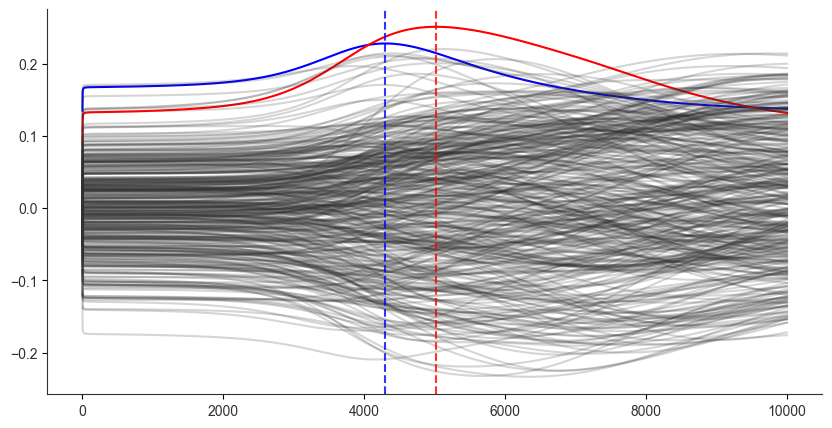

In [30]:
#------------------------------------------------------------------------------
# Visualize the similarity between the actual and the stimulated atrophy pattern
#------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams['font.family'] = 'Arial'
positive_color = [0.87, 0.47, 0.45]
gray_color     = [0.19, 0.19, 0.19]

# Determine the top two parcels
max_values = [max(corr_array[seed_id, :]) for seed_id in range(nnodes)]

top_two_indices = sorted(range(len(max_values)),
                            key=lambda i: max_values[i],
                            reverse = True)[:2]

for seed_id in range(nnodes):
    color = 'red' if seed_id == top_two_indices[0] else ('blue'
                                                            if seed_id == top_two_indices[1] else gray_color)
    alpha = 1.0 if seed_id in top_two_indices else 0.2
    plt.plot(corr_array[seed_id, :],
                color = color,
                alpha = alpha)
    
# Highlight maximum values with vertical lines
for seed_id in range(nnodes):
    color = 'red' if seed_id == top_two_indices[0] else ('blue'
                                                            if seed_id == top_two_indices[1] else gray_color)
    if seed_id in top_two_indices:
        # Find the index of the maximum value for this seed_id
        max_index = np.argmax(corr_array[seed_id, :])
        print(np.max(corr_array[seed_id, :]))
        print(seed_id)
        plt.axvline(x = max_index,
                    color = color,
                    alpha = 0.8,
                    linestyle = '--')
        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(gray_color)
ax.spines['left'].set_color(gray_color)
[ax.get_xticklabels()[i].set_color(gray_color) for i in range(len(ax.get_xticklabels()))]
[ax.get_yticklabels()[i].set_color(gray_color) for i in range(len(ax.get_yticklabels()))]
eps_filename = 'SIR_model_TMS.svg'
plt.savefig(os.path.join(path_results, eps_filename), format = 'svg', dpi = 300)
plt.show()

In [31]:
top_two_indices = sorted(range(len(max_values)),
                         key=lambda i: max_values[i],
                         reverse = True)[:2]

In [32]:
#------------------------------------------------------------------------------
# Find the maximum correlation value for each parcel and sort them accordingly
# This process will lead to an epicenter cortical map
#------------------------------------------------------------------------------
from scipy.io import savemat
max_values = np.max(corr_array, axis = 1)

# Pair region IDs with their max values
region_ids = range(nnodes)
paired = list(zip(region_ids, max_values))

# Sort based on the max values in descending order
sorted_regions = sorted(paired,
                        key = lambda x: x[1],
                        reverse = True)

# Extract sorted region IDs
sorted_region_ids = [region[0] for region in sorted_regions]
c = 400
array_to_save = np.zeros((nnodes, 1))
for i in range(nnodes):
    j = sorted_region_ids[i]
    array_to_save[j, 0] = c
    c = c - 1
    


In [33]:
# Save as mat
savemat(path_results + 'epicenterMap_SIR_TMS_S4007Net.mat', {'epicenters': array_to_save})
#------------------------------------------------------------------------------
# END